In [10]:
import pandas as pd
import numpy as np
from IPython.display import display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import os

import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics
import seaborn as sns
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings("ignore")

from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import math

In [13]:
#Ratings and Mapping
raw_ratings = pd.read_excel('S&P Ratings - Quarterly.xlsx')
#IMF - ISO
imf_iso = pd.read_excel('Mappings.xlsx', sheet_name = 'IMF - ISO')
imf_iso_mapping = dict(zip(imf_iso.iloc[:, 0], imf_iso.iloc[:, 1]))
#WB - ISO
sp_iso = pd.read_excel('Mappings.xlsx', sheet_name = 'S&P - ISO')
sp_iso_mapping = dict(zip(sp_iso.iloc[:, 0], sp_iso.iloc[:, 1]))
#S&P WDI
sp_wdi = pd.read_excel('Mappings.xlsx', sheet_name = 'SP - WDI')
#Ratings
ratings_int = pd.read_excel('Mappings.xlsx', sheet_name = 'Ratings')
ratings_mapping = dict(zip(ratings_int.iloc[:, 0], ratings_int.iloc[:, 1]))
ratings_reverse = {b:a for a, b in ratings_mapping.items()}
#Ratings No modifiers
ratings_int_NM = pd.read_excel('Mappings.xlsx', sheet_name = 'Ratings_NoMod')
ratings_mapping_NM = dict(zip(ratings_int_NM.iloc[:, 0], ratings_int_NM.iloc[:, 1]))
ratings_reverse_NM = {b:a for a, b in ratings_mapping_NM.items() if a[-1] not in ['-','+']}
#Exclude
exclusions = ['Advanced Economies', 'Emerging and Developing Asia','Emerging and Developing Countries', 'Sub-Saharan Africa',
       'Western Hemisphere', 'World']
next_mapping = {"Q1":"Q2", "Q2":"Q3","Q3":"Q4","Q4":"Q1"}
prev_mapping = {"Q1":"Q4", "Q2":"Q1","Q3":"Q2","Q4":"Q3"}

In [14]:
class MacroDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [15]:
def load_data(path, test_split = 0.25, batch_size = 64, offset = 4, seed = None, cnn = False, nn = False, 
              combined = False, idx = False):
    if seed != None:
        generator1 = torch.Generator().manual_seed(seed)
        
    #Load transformed data
    data_x = pd.read_excel(path, sheet_name = 'X')
    data_y_NM = pd.read_excel(path, sheet_name = 'y_NM').values.ravel()
    data_y_M = pd.read_excel(path, sheet_name = 'y_M').values.ravel()
    a, b = data_x.shape
    p = len(data_x.columns.tolist()[offset:])
    n = int(data_x.loc[0, 'Lag'].split('-')[1])
    m = int(a/n)
    
    pdata_x = torch.from_numpy(data_x.iloc[:, offset:].values.astype(np.float32))
    if cnn == True:
        pdata_x = pdata_x.view(m, 1, n, p)
    elif nn == True:
        pdata_x = pdata_x.view(m, p)
    else:
        pdata_x = pdata_x.view(m, n, p).float()
    pdata_y_NM = torch.tensor(data_y_NM)
    pdata_y_M = torch.tensor(data_y_M)

    
    pdata_NM = MacroDataset(pdata_x, pdata_y_NM)
    generator1 = torch.Generator().manual_seed(seed)
    train_NM_idx, test_NM_idx = torch.utils.data.random_split(range(m), [(1 - test_split), test_split], generator1)
    generator1 = torch.Generator().manual_seed(seed)
    pdata_train_NM, pdata_test_NM = torch.utils.data.random_split(pdata_NM, [(1 - test_split), test_split], generator1)
    pdata_train_loader_NM = torch.utils.data.DataLoader(pdata_train_NM, batch_size = batch_size)
    pdata_test_loader_NM = torch.utils.data.DataLoader(pdata_test_NM, batch_size = batch_size)

    pdata_M = MacroDataset(pdata_x, pdata_y_M)
    generator1 = torch.Generator().manual_seed(seed)
    train_M_idx, test_M_idx = torch.utils.data.random_split(range(m), [(1 - test_split), test_split], generator1)
    generator1 = torch.Generator().manual_seed(seed)
    pdata_train_M, pdata_test_M = torch.utils.data.random_split(pdata_M, [(1 - test_split), test_split], generator1)
    pdata_train_loader_M = torch.utils.data.DataLoader(pdata_train_M, batch_size = batch_size)
    pdata_test_loader_M = torch.utils.data.DataLoader(pdata_test_M, batch_size = batch_size)
    
    if combined == True:
        return pdata_x, pdata_y_NM, pdata_y_M
    
    if idx == True:
        return pdata_train_loader_NM, pdata_test_loader_NM, pdata_train_loader_M, pdata_test_loader_M, list(train_NM_idx), test_NM_idx, train_M_idx, test_M_idx
    
    return pdata_train_loader_NM, pdata_test_loader_NM, pdata_train_loader_M, pdata_test_loader_M

In [16]:
# Fully connected RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout = 0, bidirectional = False):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout, bidirectional = bidirectional)
        # -> x needs to be: (batch_size, seq, input_size)
        
        if self.bidirectional == True:
            self.fc = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        
        if self.bidirectional == True:
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate RNN
        out, _ = self.rnn(x, h0)  
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
         
        out = self.fc(out)
        return out
    
# Fully connected LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout = 0, bidirectional = False):
        super(LSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout = dropout, bidirectional = bidirectional)
        # -> x needs to be: (batch_size, seq, input_size)
        
        if self.bidirectional == True:
            self.fc = nn.Linear(hidden_size * 2, num_classes)
        else:
            self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Set initial hidden states (and cell states for LSTM)
        
        if self.bidirectional == True:
            h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
            c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device) 
        else:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate RNN
        out, _ = self.lstm(x, (h0,c0))  
        
        # Decode the hidden state of the last time step
        out = out[:, -1, :]
         
        out = self.fc(out)
        return out

#2D CNN
class CNN(nn.Module):
    def __init__(self, in_channels, input_size, sequence_length, num_classes, kernel_p = 2, dropout = 0, l_layers = 1):
        super(CNN, self).__init__()
        self.l_layers = l_layers
        self.conv1 = nn.Conv2d(in_channels, out_channels = 8, kernel_size = (3, 3), stride = (1,1), padding = (1,1))
        self.pool = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3), stride = (1,1), padding = (1,1))
        a = sequence_length//2
        a = a//2
        b = input_size//2
        b = b//2
        if self.l_layers == 1:
            self.fc1 = nn.Linear(16 * a * b, num_classes)
        else:
            self.fc1 = nn.Linear(16 * a * b, 16 * a * b)
            self.fc2 = nn.Linear(16 * a * b, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(x)
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        if self.l_layers != 1:
            x = self.dropout(x)
            x = self.fc2(x)
        
        return x
    
#2 Layer NN
class NN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, dropout = 0):
        super(NN, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        
        return out

In [29]:
def train_model(model, criterion, optimizer, train_data, test_data, num_epochs = 100):
    # Train the model
    n_total_steps = len(train_data)
    train_acc = []
    test_acc = []
    for epoch in range(num_epochs):
        for i, (x_var, labels) in enumerate(train_data):  
            labels = labels.to(device)
            x_var = x_var.to(device)

            # Forward pass
            outputs = model(x_var)
            outputs = outputs.to(device)
            loss = criterion(outputs, labels)
            loss = loss.to(device)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        #Accuracy
        n_correct = 0
        n_samples = 0
        for x_var, labels in train_data:
            x_var = x_var.to(device)
            labels = labels.to(device)
            outputs = model(x_var)
            # max returns (value ,index)
            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
        acc = 100.0 * n_correct / n_samples
        train_acc.append(acc)
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}, Training Accuracy: {round(acc,2)} %')

        with torch.no_grad():
            n_correct = 0
            n_samples = 0
            for x_var, labels in test_data:
                labels = labels.to(device)
                x_var = x_var.to(device)
                outputs = model(x_var)
                # max returns (value ,index)
                _, predicted = torch.max(outputs.data, 1)
                n_samples += labels.size(0)
                n_correct += (predicted == labels).sum().item()

            acc = 100.0 * n_correct / n_samples
            test_acc.append(acc)
        
    print(f'Testing Accuracy: {round(acc,2)} %')
    
    return train_acc, test_acc

In [18]:
#Seed
seed = 10101010101010101010

#Load Data, Lag = 4
path = 'Data_XY_L4_v3.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

#Sample Data
sample_x, sample_y = next(iter(train_NM))
print('Input Shape:')
print(sample_x.shape)
print('Sample X:')
print(sample_x[0])
print('Sample Y:')
print(sample_y[0])

Input Shape:
torch.Size([64, 4, 24])
Sample X:
tensor([[-1.4373e-01, -8.8219e-01, -2.2808e-02,  1.0343e-01,  8.3682e-01,
          7.9832e-02,  7.3751e-02,  9.2080e-02,  5.6295e-02, -2.8486e-01,
          1.7868e-01, -5.1286e-01, -6.6884e-01,  2.9504e-02,  9.4986e-02,
          9.3147e-02, -9.0913e-02,  4.1444e-02, -5.4302e-01,  2.0164e-01,
          3.8876e-01, -3.6092e-01, -5.9146e-01,  2.1075e-01],
        [-1.4258e-01, -8.8224e-01, -1.2463e-02,  1.2187e-01,  9.3096e-01,
          7.9469e-02,  8.0630e-02,  9.2115e-02,  3.7746e-02, -1.7947e-01,
         -9.6900e-01, -4.8760e-01, -6.6630e-01,  2.8964e-02,  9.5003e-02,
          9.3779e-02, -9.0320e-02,  3.9626e-02, -5.1493e-01,  1.9889e-01,
          3.7908e-01, -3.7390e-01, -6.1615e-01,  2.2103e-01],
        [-1.3586e-01, -8.8046e-01,  3.6883e-03,  1.3408e-01,  1.0368e+00,
          7.9539e-02,  6.9929e-02,  9.2048e-02,  2.2630e-02, -5.3718e-02,
          1.9651e-02, -5.0722e-01, -6.6419e-01,  2.8364e-02,  9.5004e-02,
          9.411

Lag = 4 with No Rating Modifiers
-----------------------------
RNN with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 60.59 %
Epoch: 100, Training Accuracy: 97.08 %
Epoch: 200, Training Accuracy: 98.62 %
Testing Accuracy: 95.22 %


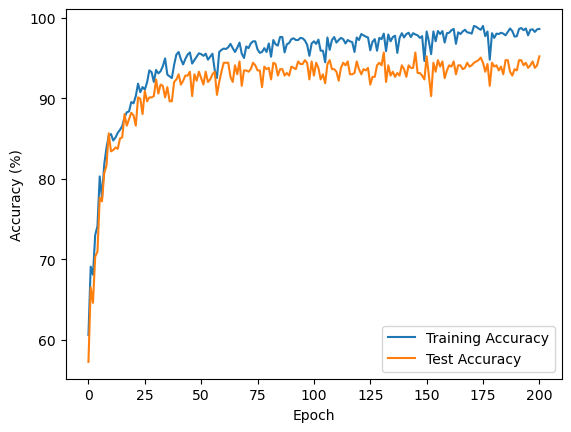

-----------------------------
Bi-Directional RNN with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 63.09 %
Epoch: 100, Training Accuracy: 97.93 %
Epoch: 200, Training Accuracy: 99.1 %
Testing Accuracy: 94.58 %
-----------------------------
LSTM with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 57.62 %
Epoch: 100, Training Accuracy: 98.73 %
Epoch: 200, Training Accuracy: 99.68 %
Testing Accuracy: 95.53 %
-----------------------------
Bi-Directional LSTM with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 59.11 %
Epoch: 100, Training Accuracy: 99.31 %
Epoch: 200, Training Accuracy: 99.36 %
Testing Accuracy: 94.26 %
-----------------------------
CNN with No Ratings Modifiers - 1 Linear Layer
-----------------------------
Epoch: 0, Training Accuracy: 11.21 %
Epoch: 100, Training Accuracy: 39.14 %
Epoch: 200, Training Accuracy: 40.41 %
Epoch: 300, Training Accuracy: 43.12 %
Epoch: 400, Tra

In [24]:
#Load Data, Lag = 4
path = 'Data_XY_L4_v3.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

print('Lag = 4 with No Rating Modifiers')
print('-----------------------------')
# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.5
num_classes = 10
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2


#RNN No Rating Modifiers
model_RNN_NM = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM.parameters(), lr=learning_rate)
print('RNN with No Ratings Modifiers')
print('-----------------------------')
train_acc, test_acc = train_model(model_RNN_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc,label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()
print('-----------------------------')

#Bi-Directional RNN No Rating Modifiers
model_RNN_NM_Bi = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM_Bi.parameters(), lr=learning_rate)
print('Bi-Directional RNN with No Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_NM_Bi, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')


#LSTM No Rating Modifiers
model_LSTM_NM = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM.parameters(), lr=learning_rate)
print('LSTM with No Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')


#Bi-Directional LSTM No Rating Modifiers
model_LSTM_NM_Bi = LSTM(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM_Bi.parameters(), lr=learning_rate)
print('Bi-Directional LSTM with No Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_NM_Bi, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

#Load CNN Data
train_NM, test_NM, train_M, test_M = load_data(path, cnn = True, seed = seed)

#Hyper-parameters 
num_epochs = 1001

input_size = next(iter(train_NM))[0].size()[3]
sequence_length = next(iter(train_NM))[0].size()[2]

model_CNN_NM_1 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.SGD(model_CNN_NM_1.parameters(), lr=learning_rate)

print('CNN with No Ratings Modifiers - 1 Linear Layer')
print('-----------------------------')
train_model(model_CNN_NM_1, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

model_CNN_NM_2 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout, l_layers = 2).to(device)
optimizer = torch.optim.SGD(model_CNN_NM_2.parameters(), lr=learning_rate)

print('CNN with No Ratings Modifiers - 2 Linear Layer')
print('-----------------------------')
train_model(model_CNN_NM_2, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

In [25]:
#Load Data, Lag = 4
path = 'Data_XY_L4_v2.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

print('Lag = 4 with Rating Modifiers')
print('-----------------------------')
# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.5
num_classes = 22
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2

#RNN with Rating Modifiers
model_RNN_M = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M.parameters(), lr=learning_rate)
print('RNN with Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional RNN with Rating Modifiers
model_RNN_M_Bi = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M_Bi.parameters(), lr=learning_rate)
print('Bi-Directional RNN with Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_M_Bi, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#LSTM with Rating Modifiers
model_LSTM_M = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M.parameters(), lr=learning_rate)
print('LSTM with Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional LSTM with Rating Modifiers
model_LSTM_M_Bi = LSTM(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M_Bi.parameters(), lr=learning_rate)
print('Bi-Directional LSTM with Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_M_Bi, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Load CNN Data
train_NM, test_NM, train_M, test_M = load_data(path, cnn = True, seed = seed)

#Hyper-parameters 
num_epochs = 1001

input_size = next(iter(train_M))[0].size()[3]
sequence_length = next(iter(train_M))[0].size()[2]

model_CNN_M_1 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.SGD(model_CNN_M_1.parameters(), lr=learning_rate)

print('CNN with Ratings Modifiers - 1 Linear Layer')
print('-----------------------------')
train_model(model_CNN_M_1, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

model_CNN_M_2 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout, l_layers = 2).to(device)
optimizer = torch.optim.SGD(model_CNN_M_2.parameters(), lr=learning_rate)

print('CNN with Ratings Modifiers - 2 Linear Layer')
print('-----------------------------')
train_model(model_CNN_M_2, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

Lag = 4 with Rating Modifiers
-----------------------------
RNN with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 37.65 %
Epoch: 100, Training Accuracy: 95.7 %
Epoch: 200, Training Accuracy: 97.61 %
Testing Accuracy: 85.81 %
-----------------------------
Bi-Directional RNN with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 41.0 %
Epoch: 100, Training Accuracy: 97.08 %
Epoch: 200, Training Accuracy: 99.15 %
Testing Accuracy: 85.33 %
-----------------------------
LSTM with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 30.54 %
Epoch: 100, Training Accuracy: 95.75 %
Epoch: 200, Training Accuracy: 99.26 %
Testing Accuracy: 85.96 %
-----------------------------
Bi-Directional LSTM with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 32.93 %
Epoch: 100, Training Accuracy: 98.67 %
Epoch: 200, Training Accuracy: 99.52 %
Testing Accuracy: 88.36 %
----------------------------

In [10]:
#Load Data, Lag = 5
path = 'Data_XY_L5_v2.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

print('Lag = 5 with No Rating Modifiers')
print('-----------------------------')
# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.075
num_classes = 10
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2

#RNN No Rating Modifiers
model_RNN_NM = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM.parameters(), lr=learning_rate)
print('RNN with No Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional RNN No Rating Modifiers
model_RNN_NM_Bi = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM_Bi.parameters(), lr=learning_rate)
print('Bi-Directional RNN with No Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_NM_Bi, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')


#LSTM No Rating Modifiers
model_LSTM_NM = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM.parameters(), lr=learning_rate)
print('LSTM with No Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')


#Bi-Directional LSTM No Rating Modifiers
model_LSTM_NM_Bi = LSTM(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM_Bi.parameters(), lr=learning_rate)
print('Bi-Directional LSTM with No Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_NM_Bi, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

#Load CNN Data
train_NM, test_NM, train_M, test_M = load_data(path, cnn = True, seed = seed)

#Hyper-parameters 
num_epochs = 1001

input_size = next(iter(train_NM))[0].size()[3]
sequence_length = next(iter(train_NM))[0].size()[2]


model_CNN_NM_1 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.SGD(model_CNN_NM_1.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 1 Linear Layer')
print('-----------------------------')
train_model(model_CNN_NM_1, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

model_CNN_NM_2 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout, l_layers = 2).to(device)
optimizer = torch.optim.SGD(model_CNN_NM_2.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 2 Linear Layer')
print('-----------------------------')
train_model(model_CNN_NM_2, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

Lag = 5 with No Rating Modifiers
-----------------------------
RNN with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 61.2 %
Epoch: 100, Training Accuracy: 97.24 %
Epoch: 200, Training Accuracy: 99.19 %
Testing Accuracy: 93.66 %
-----------------------------
Bi-Directional RNN with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 65.15 %
Epoch: 100, Training Accuracy: 97.24 %
Epoch: 200, Training Accuracy: 99.24 %
Testing Accuracy: 93.82 %
-----------------------------
LSTM with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 57.79 %
Epoch: 100, Training Accuracy: 99.08 %
Epoch: 200, Training Accuracy: 99.13 %
Testing Accuracy: 93.17 %
-----------------------------
Bi-Directional LSTM with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 60.5 %
Epoch: 100, Training Accuracy: 98.05 %
Epoch: 200, Training Accuracy: 98.38 %
Testing Accuracy: 92.85 %
-------------

In [11]:
#Load Data, Lag = 5
path = 'Data_XY_L5_v2.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

print('Lag = 5 with Rating Modifiers')
print('-----------------------------')
# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.075
num_classes = 22
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2

#RNN with Rating Modifiers
model_RNN_M = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M.parameters(), lr=learning_rate)
print('RNN with Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional RNN with Rating Modifiers
model_RNN_M_Bi = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M_Bi.parameters(), lr=learning_rate)
print('Bi-Directional RNN with Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_M_Bi, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#LSTM with Rating Modifiers
model_LSTM_M = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M.parameters(), lr=learning_rate)
print('LSTM with Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional LSTM with Rating Modifiers
model_LSTM_M_Bi = LSTM(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M_Bi.parameters(), lr=learning_rate)
print('Bi-Directional LSTM with Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_M_Bi, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Load CNN Data
train_NM, test_NM, train_M, test_M = load_data(path, cnn = True, seed = seed)

#Hyper-parameters 
num_epochs = 1001

input_size = next(iter(train_M))[0].size()[3]
sequence_length = next(iter(train_M))[0].size()[2]

model_CNN_M_1 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.SGD(model_CNN_M_1.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 1 Linear Layer')
print('-----------------------------')
train_model(model_CNN_M_1, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

model_CNN_M_2 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout, l_layers = 2).to(device)
optimizer = torch.optim.SGD(model_CNN_M_2.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 2 Linear Layer')
print('-----------------------------')
train_model(model_CNN_M_2, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

Lag = 5 with Rating Modifiers
-----------------------------
RNN with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 37.12 %
Epoch: 100, Training Accuracy: 95.89 %
Epoch: 200, Training Accuracy: 98.0 %
Testing Accuracy: 88.13 %
-----------------------------
Bi-Directional RNN with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 38.31 %
Epoch: 100, Training Accuracy: 99.03 %
Epoch: 200, Training Accuracy: 98.97 %
Testing Accuracy: 86.67 %
-----------------------------
LSTM with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 31.93 %
Epoch: 100, Training Accuracy: 98.43 %
Epoch: 200, Training Accuracy: 98.38 %
Testing Accuracy: 86.18 %
-----------------------------
Bi-Directional LSTM with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 29.76 %
Epoch: 100, Training Accuracy: 98.86 %
Epoch: 200, Training Accuracy: 99.4 %
Testing Accuracy: 88.78 %
----------------------------

In [26]:
#Load Data, Lag = 6
path = 'Data_XY_L6_v2.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

print('Lag = 6 with No Rating Modifiers')
print('-----------------------------')
# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.5
num_classes = 10
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2

#RNN No Rating Modifiers
model_RNN_NM = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM.parameters(), lr=learning_rate)
print('RNN with No Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional RNN No Rating Modifiers
model_RNN_NM_Bi = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM_Bi.parameters(), lr=learning_rate)
print('Bi-Directional RNN with No Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_NM_Bi, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')


#LSTM No Rating Modifiers
model_LSTM_NM = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM.parameters(), lr=learning_rate)
print('LSTM with No Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')


#Bi-Directional LSTM No Rating Modifiers
model_LSTM_NM_Bi = LSTM(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM_Bi.parameters(), lr=learning_rate)
print('Bi-Directional LSTM with No Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_NM_Bi, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

#Load CNN Data
train_NM, test_NM, train_M, test_M = load_data(path, cnn = True, seed = seed)

#Hyper-parameters 
num_epochs = 1001

input_size = next(iter(train_NM))[0].size()[3]
sequence_length = next(iter(train_NM))[0].size()[2]


model_CNN_NM_1 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.SGD(model_CNN_NM_1.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 1 Linear Layer')
print('-----------------------------')
train_model(model_CNN_NM_1, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

model_CNN_NM_2 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout, l_layers = 2).to(device)
optimizer = torch.optim.SGD(model_CNN_NM_2.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 2 Linear Layer')
print('-----------------------------')
train_model(model_CNN_NM_2, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

Lag = 6 with No Rating Modifiers
-----------------------------
RNN with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 64.99 %
Epoch: 100, Training Accuracy: 96.42 %
Epoch: 200, Training Accuracy: 98.29 %
Testing Accuracy: 92.55 %
-----------------------------
Bi-Directional RNN with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 67.48 %
Epoch: 100, Training Accuracy: 97.85 %
Epoch: 200, Training Accuracy: 98.57 %
Testing Accuracy: 94.54 %
-----------------------------
LSTM with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 62.46 %
Epoch: 100, Training Accuracy: 98.73 %
Epoch: 200, Training Accuracy: 99.06 %
Testing Accuracy: 93.54 %
-----------------------------
Bi-Directional LSTM with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 65.55 %
Epoch: 100, Training Accuracy: 98.07 %
Epoch: 200, Training Accuracy: 98.9 %
Testing Accuracy: 95.7 %
-------------

In [13]:
#Load Data, Lag = 6
path = 'Data_XY_L6_v2.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

print('Lag = 6 with Rating Modifiers')
print('-----------------------------')
# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.075
num_classes = 22
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2

#RNN with Rating Modifiers
model_RNN_M = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M.parameters(), lr=learning_rate)
print('RNN with Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional RNN with Rating Modifiers
model_RNN_M_Bi = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M_Bi.parameters(), lr=learning_rate)
print('Bi-Directional RNN with Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_M_Bi, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#LSTM with Rating Modifiers
model_LSTM_M = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M.parameters(), lr=learning_rate)
print('LSTM with Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional LSTM with Rating Modifiers
model_LSTM_M_Bi = LSTM(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M_Bi.parameters(), lr=learning_rate)
print('Bi-Directional LSTM with Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_M_Bi, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Load CNN Data
train_NM, test_NM, train_M, test_M = load_data(path, cnn = True, seed = seed)

#Hyper-parameters 
num_epochs = 1001

input_size = next(iter(train_M))[0].size()[3]
sequence_length = next(iter(train_M))[0].size()[2]

model_CNN_M_1 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.SGD(model_CNN_M_1.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 1 Linear Layer')
print('-----------------------------')
train_model(model_CNN_M_1, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

model_CNN_M_2 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout, l_layers = 2).to(device)
optimizer = torch.optim.SGD(model_CNN_M_2.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 2 Linear Layer')
print('-----------------------------')
train_model(model_CNN_M_2, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

Lag = 6 with Rating Modifiers
-----------------------------
RNN with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 40.02 %
Epoch: 100, Training Accuracy: 95.92 %
Epoch: 200, Training Accuracy: 96.8 %
Testing Accuracy: 86.59 %
-----------------------------
Bi-Directional RNN with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 46.53 %
Epoch: 100, Training Accuracy: 96.64 %
Epoch: 200, Training Accuracy: 97.52 %
Testing Accuracy: 84.93 %
-----------------------------
LSTM with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 38.81 %
Epoch: 100, Training Accuracy: 98.13 %
Epoch: 200, Training Accuracy: 98.35 %
Testing Accuracy: 85.93 %
-----------------------------
Bi-Directional LSTM with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 37.21 %
Epoch: 100, Training Accuracy: 96.75 %
Epoch: 200, Training Accuracy: 99.67 %
Testing Accuracy: 88.91 %
---------------------------

In [14]:
#Load Data, Lag = 24
path = 'Data_XY_L24_v2.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

print('Lag = 24 with No Rating Modifiers')
print('-----------------------------')
# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.075
num_classes = 10
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2

#RNN No Rating Modifiers
model_RNN_NM = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM.parameters(), lr=learning_rate)
print('RNN with No Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional RNN No Rating Modifiers
model_RNN_NM_Bi = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM_Bi.parameters(), lr=learning_rate)
print('Bi-Directional RNN with No Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_NM_Bi, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')


#LSTM No Rating Modifiers
model_LSTM_NM = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM.parameters(), lr=learning_rate)
print('LSTM with No Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')


#Bi-Directional LSTM No Rating Modifiers
model_LSTM_NM_Bi = LSTM(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM_Bi.parameters(), lr=learning_rate)
print('Bi-Directional LSTM with No Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_NM_Bi, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

#Load CNN Data
train_NM, test_NM, train_M, test_M = load_data(path, cnn = True, seed = seed)

#Hyper-parameters 
num_epochs = 1001

input_size = next(iter(train_NM))[0].size()[3]
sequence_length = next(iter(train_NM))[0].size()[2]


model_CNN_NM_1 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.SGD(model_CNN_NM_1.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 1 Linear Layer')
print('-----------------------------')
train_model(model_CNN_NM_1, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

model_CNN_NM_2 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout, l_layers = 2).to(device)
optimizer = torch.optim.SGD(model_CNN_NM_2.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 2 Linear Layer')
print('-----------------------------')
train_model(model_CNN_NM_2, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

Lag = 24 with No Rating Modifiers
-----------------------------
RNN with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 60.11 %
Epoch: 100, Training Accuracy: 99.68 %
Epoch: 200, Training Accuracy: 99.45 %
Testing Accuracy: 95.73 %
-----------------------------
Bi-Directional RNN with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 64.3 %
Epoch: 100, Training Accuracy: 100.0 %
Epoch: 200, Training Accuracy: 100.0 %
Testing Accuracy: 95.97 %
-----------------------------
LSTM with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 61.45 %
Epoch: 100, Training Accuracy: 97.95 %
Epoch: 200, Training Accuracy: 98.58 %
Testing Accuracy: 95.73 %
-----------------------------
Bi-Directional LSTM with No Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 61.37 %
Epoch: 100, Training Accuracy: 99.45 %
Epoch: 200, Training Accuracy: 99.53 %
Testing Accuracy: 96.21 %
-----------

In [15]:
#Load Data, Lag = 24
path = 'Data_XY_L24_v2.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

print('Lag = 24 with Rating Modifiers')
print('-----------------------------')
# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.075
num_classes = 22
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2

#RNN with Rating Modifiers
model_RNN_M = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M.parameters(), lr=learning_rate)
print('RNN with Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional RNN with Rating Modifiers
model_RNN_M_Bi = RNN(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M_Bi.parameters(), lr=learning_rate)
print('Bi-Directional RNN with Ratings Modifiers')
print('-----------------------------')
train_model(model_RNN_M_Bi, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#LSTM with Rating Modifiers
model_LSTM_M = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M.parameters(), lr=learning_rate)
print('LSTM with Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Bi-Directional LSTM with Rating Modifiers
model_LSTM_M_Bi = LSTM(input_size, hidden_size, num_layers, num_classes, bidirectional = True, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M_Bi.parameters(), lr=learning_rate)
print('Bi-Directional LSTM with Ratings Modifiers')
print('-----------------------------')
train_model(model_LSTM_M_Bi, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

#Load CNN Data
train_NM, test_NM, train_M, test_M = load_data(path, cnn = True, seed = seed)

#Hyper-parameters 
num_epochs = 1001

input_size = next(iter(train_M))[0].size()[3]
sequence_length = next(iter(train_M))[0].size()[2]

model_CNN_M_1 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.SGD(model_CNN_M_1.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 1 Linear Layer')
print('-----------------------------')
train_model(model_CNN_M_1, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

model_CNN_M_2 = CNN(1, input_size, sequence_length, num_classes, dropout = dropout, l_layers = 2).to(device)
optimizer = torch.optim.SGD(model_CNN_M_2.parameters(), lr=learning_rate)
print('CNN with No Ratings Modifiers - 2 Linear Layer')
print('-----------------------------')
train_model(model_CNN_M_2, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

Lag = 24 with Rating Modifiers
-----------------------------
RNN with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 37.84 %
Epoch: 100, Training Accuracy: 99.76 %
Epoch: 200, Training Accuracy: 99.92 %
Testing Accuracy: 92.18 %
-----------------------------
Bi-Directional RNN with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 38.94 %
Epoch: 100, Training Accuracy: 99.76 %
Epoch: 200, Training Accuracy: 99.37 %
Testing Accuracy: 91.71 %
-----------------------------
LSTM with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 33.41 %
Epoch: 100, Training Accuracy: 95.18 %
Epoch: 200, Training Accuracy: 99.21 %
Testing Accuracy: 92.89 %
-----------------------------
Bi-Directional LSTM with Ratings Modifiers
-----------------------------
Epoch: 0, Training Accuracy: 33.97 %
Epoch: 100, Training Accuracy: 98.66 %
Epoch: 200, Training Accuracy: 99.05 %
Testing Accuracy: 92.65 %
-------------------------

In [16]:
#Load Data, Lag = 1
path = 'Data_XY_L1_v2.xlsx'
train_NM, test_NM, train_M, test_M = load_data(path, seed = seed, nn = True)

data_X = pd.read_excel('Data_XY_L1_v2.xlsx', sheet_name = 'X')
data_y_NM = pd.read_excel('Data_XY_L1_v2.xlsx', sheet_name = 'y_NM')
data_y_M = pd.read_excel('Data_XY_L1_v2.xlsx', sheet_name = 'y_M')

# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.075
num_classes = 10
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[1]

hidden_size = 128  
model_NN_NM_128 = NN(input_size, hidden_size, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_NN_NM_128.parameters(), lr=learning_rate)
print('NN with No Ratings Modifiers - 2 Layers, 128 Hidden Size')
print('-----------------------------')
train_model(model_NN_NM_128, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')


hidden_size = 256
model_NN_NM_256 = NN(input_size, hidden_size, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_NN_NM_256.parameters(), lr=learning_rate)
print('NN with No Ratings Modifiers - 2 Layers, 256 Hidden Size')
print('-----------------------------')
train_model(model_NN_NM_256, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)
print('-----------------------------')

NN with No Ratings Modifiers - 2 Layers, 128 Hidden Size
-----------------------------
Epoch: 0, Training Accuracy: 49.26 %
Epoch: 100, Training Accuracy: 96.23 %
Epoch: 200, Training Accuracy: 98.16 %
Testing Accuracy: 94.78 %
-----------------------------
NN with No Ratings Modifiers - 2 Layers, 256 Hidden Size
-----------------------------
Epoch: 0, Training Accuracy: 54.07 %
Epoch: 100, Training Accuracy: 97.52 %
Epoch: 200, Training Accuracy: 99.26 %
Testing Accuracy: 95.83 %
-----------------------------


In [17]:
# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.075
num_classes = 22
criterion = nn.CrossEntropyLoss()

input_size = next(iter(train_NM))[0].size()[1]

hidden_size = 128  
model_NN_M_128 = NN(input_size, hidden_size, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_NN_M_128.parameters(), lr=learning_rate)
print('NN with Ratings Modifiers - 2 Layers, 128 Hidden Size')
print('-----------------------------')
train_model(model_NN_M_128, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')


hidden_size = 256
model_NN_M_256 = NN(input_size, hidden_size, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_NN_M_256.parameters(), lr=learning_rate)
print('NN with Ratings Modifiers - 2 Layers, 256 Hidden Size')
print('-----------------------------')
train_model(model_NN_M_256, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)
print('-----------------------------')

NN with Ratings Modifiers - 2 Layers, 128 Hidden Size
-----------------------------
Epoch: 0, Training Accuracy: 29.41 %
Epoch: 100, Training Accuracy: 86.9 %
Epoch: 200, Training Accuracy: 93.06 %
Testing Accuracy: 81.67 %
-----------------------------
NN with Ratings Modifiers - 2 Layers, 256 Hidden Size
-----------------------------
Epoch: 0, Training Accuracy: 32.79 %
Epoch: 100, Training Accuracy: 90.38 %
Epoch: 200, Training Accuracy: 95.93 %
Testing Accuracy: 84.2 %
-----------------------------


In [18]:
data_X = pd.read_excel('Data_XY_L1_v2.xlsx', sheet_name = 'X').iloc[:, 4:].values
data_y_NM = pd.read_excel('Data_XY_L1_v2.xlsx', sheet_name = 'y_NM').values.ravel()
data_y_M = pd.read_excel('Data_XY_L1_v2.xlsx', sheet_name = 'y_M').values.ravel()

#Q3.b - Train - Test Split
data_X_train, data_X_test, data_y_NM_train, data_y_NM_test = train_test_split(data_X, data_y_NM, test_size=0.25, random_state = 0, shuffle = True)
data_X_train, data_X_test, data_y_M_train, data_y_M_test = train_test_split(data_X, data_y_M, test_size=0.25, random_state = 0, shuffle = True)

In [19]:
#Random Forest with No Ratings Modifier
print('Random Forest with No Ratings Modifiers')
print('-----------------------------')
#Hyperparameter tuning
features_list = list(range(5,16))
trees_list = list(range(100, 501, 100))
hyperparameters = dict(max_features = features_list,  n_estimators = trees_list)
RF_temp = RandomForestClassifier(random_state = 0, n_jobs = -1)
RF_CV = GridSearchCV(RF_temp, hyperparameters, n_jobs = -1)
#Fit data based on best model found
RF_best = RF_CV.fit(data_X_train, data_y_NM_train)
#Display best trees and max features
best_features = RF_best.best_estimator_.get_params()['max_features']
best_n = RF_best.best_estimator_.get_params()['n_estimators']
print('Best max features:', best_features)
print('Best Number of Trees:', best_n)
print('-----------------------------')
RF_NM = RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = best_n, max_features = best_features)
RF_NM.fit(data_X_train, data_y_NM_train)
RF_score_train = RF_NM.score(data_X_train, data_y_NM_train)
RF_score = RF_NM.score(data_X_test, data_y_NM_test)
print('Training Accuracy:', str(((RF_score_train) * 100).round(2)) + '%')
print('Testing Accuracy:', str(((RF_score) * 100).round(2)) + '%')
print('-----------------------------')

Random Forest with No Ratings Modifiers
-----------------------------
Best max features: 5
Best Number of Trees: 400
-----------------------------
Training Accuracy: 100.0%
Testing Accuracy: 95.83%
-----------------------------


In [20]:
#Random Forest with Ratings Modifier
print('Random Forest with Ratings Modifiers')
print('-----------------------------')
#Hyperparameter tuning
features_list = list(range(5,16))
trees_list = list(range(100, 501, 100))
hyperparameters = dict(max_features = features_list,  n_estimators = trees_list)
RF_temp = RandomForestClassifier(random_state = 0, n_jobs = -1)
RF_CV = GridSearchCV(RF_temp, hyperparameters, n_jobs = -1)
#Fit data based on best model found
RF_best = RF_CV.fit(data_X_train, data_y_M_train)
#Display best trees and max features
best_features = RF_best.best_estimator_.get_params()['max_features']
best_n = RF_best.best_estimator_.get_params()['n_estimators']
print('Best max features:', best_features)
print('Best Number of Trees:', best_n)
print('-----------------------------')
RF_M = RandomForestClassifier(random_state = 0, n_jobs = -1, n_estimators = best_n, max_features = best_features)
RF_M.fit(data_X_train, data_y_M_train)
RF_score_train = RF_M.score(data_X_train, data_y_M_train)
RF_score = RF_M.score(data_X_test, data_y_M_test)
print('Training Accuracy:', str(((RF_score_train) * 100).round(2)) + '%')
print('Testing Accuracy:', str(((RF_score) * 100).round(2)) + '%')
print('-----------------------------')

Random Forest with Ratings Modifiers
-----------------------------
Best max features: 5
Best Number of Trees: 100
-----------------------------
Training Accuracy: 100.0%
Testing Accuracy: 91.37%
-----------------------------


In [21]:
#Load Data, Lag = 6
#Load transformed data
path = 'Data_XY_L6_v2.xlsx'
offset = 4
batch_size = 64

data_x = pd.read_excel(path, sheet_name = 'X')
data_y_NM = pd.read_excel(path, sheet_name = 'y_NM').values.ravel()
data_y_M = pd.read_excel(path, sheet_name = 'y_M').values.ravel()
data_meta = data_x.iloc[:, :3].drop_duplicates().reset_index(drop = True)
a, b = data_x.shape
p = len(data_x.columns.tolist()[offset:])
n = int(data_x.loc[0, 'Lag'].split('-')[1])
m = int(a/n)
pdata_x = torch.from_numpy(data_x.iloc[:, offset:].values.astype(np.float32))
pdata_y_NM = torch.tensor(data_y_NM)
pdata_y_M = torch.tensor(data_y_M)
pdata_x = pdata_x.view(m, n, p).float()

split = 0.75
m_train = math.ceil(m * split)
m_test = math.floor(m * (1 - split))

generator1 = torch.Generator().manual_seed(seed)
m_perm = torch.randperm(m, generator = generator1)
train_idx = m_perm[:m_train]
test_idx = m_perm[m_train:]
pdata_x_train = pdata_x[train_idx, :]
pdata_x_test = pdata_x[test_idx, :]
pdata_y_NM_train = pdata_y_NM[train_idx]
pdata_y_NM_test = pdata_y_NM[test_idx]
pdata_y_M_train = pdata_y_M[train_idx]
pdata_y_M_test = pdata_y_M[test_idx]

pdata_train_NM = MacroDataset(pdata_x_train, pdata_y_NM_train)
pdata_test_NM = MacroDataset(pdata_x_test, pdata_y_NM_test)
pdata_train_M = MacroDataset(pdata_x_train, pdata_y_M_train)
pdata_test_M = MacroDataset(pdata_x_test, pdata_y_M_test)

train_NM = torch.utils.data.DataLoader(pdata_train_NM, batch_size = batch_size)
test_NM = torch.utils.data.DataLoader(pdata_test_NM, batch_size = batch_size)
train_M = torch.utils.data.DataLoader(pdata_train_M, batch_size = batch_size)
test_M = torch.utils.data.DataLoader(pdata_test_M, batch_size = batch_size)

# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.075

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2

num_classes = 10
criterion = nn.CrossEntropyLoss()
#RNN No Rating Modifiers
model_RNN_NM = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM.parameters(), lr=learning_rate)
train_model(model_RNN_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)

#LSTM No Rating Modifiers
model_LSTM_NM = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM.parameters(), lr=learning_rate)
train_model(model_LSTM_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)

num_classes = 22
criterion = nn.CrossEntropyLoss()
#RNN Rating Modifiers
model_RNN_M = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M.parameters(), lr=learning_rate)
train_model(model_RNN_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)

#LSTM Rating Modifiers
model_LSTM_M = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M.parameters(), lr=learning_rate)
train_model(model_LSTM_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)

Epoch: 0, Training Accuracy: 65.16 %
Epoch: 100, Training Accuracy: 98.29 %
Epoch: 200, Training Accuracy: 98.84 %
Testing Accuracy: 94.54 %
Epoch: 0, Training Accuracy: 65.44 %
Epoch: 100, Training Accuracy: 98.73 %
Epoch: 200, Training Accuracy: 99.72 %
Testing Accuracy: 94.87 %
Epoch: 0, Training Accuracy: 41.12 %
Epoch: 100, Training Accuracy: 95.48 %
Epoch: 200, Training Accuracy: 97.24 %
Testing Accuracy: 85.76 %
Epoch: 0, Training Accuracy: 35.39 %
Epoch: 100, Training Accuracy: 96.86 %
Epoch: 200, Training Accuracy: 99.5 %
Testing Accuracy: 86.92 %


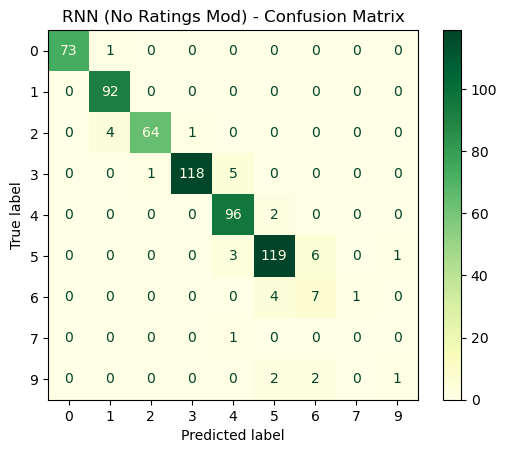

In [22]:
labels_list = []
predict_list = []
for x_var, labels in test_NM:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_RNN_NM(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
labels_RNN = np.sort(np.unique(np.concatenate((labels_list, predict_list))))
cmatrix_RNN_NM = confusion_matrix(labels_list, predict_list)
disp_RNN_NM = ConfusionMatrixDisplay(confusion_matrix = cmatrix_RNN_NM, display_labels = labels_RNN)
disp_RNN_NM.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('RNN (No Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_RNN_NM.png')
plt.show()

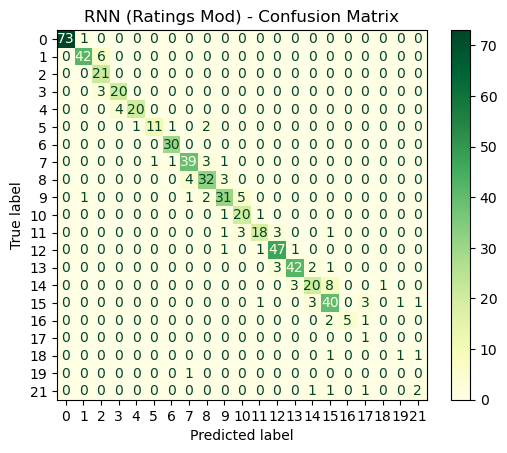

In [23]:
labels_list = []
predict_list = []
for x_var, labels in test_M:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_RNN_M(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
labels_RNN = np.sort(np.unique(np.concatenate((labels_list, predict_list))))
cmatrix_RNN_M = confusion_matrix(labels_list, predict_list)
disp_RNN_M = ConfusionMatrixDisplay(confusion_matrix = cmatrix_RNN_M, display_labels = labels_RNN)
disp_RNN_M.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('RNN (Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_RNN_M.png')
plt.show()

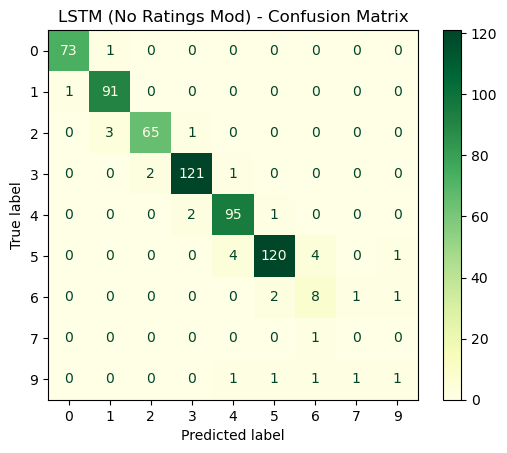

In [24]:
labels_list = []
predict_list = []
for x_var, labels in test_NM:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_LSTM_NM(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
labels_LSTM = np.sort(np.unique(np.concatenate((labels_list, predict_list))))
cmatrix_LSTM_NM = confusion_matrix(labels_list, predict_list)
disp_LSTM_NM = ConfusionMatrixDisplay(confusion_matrix = cmatrix_LSTM_NM, display_labels = labels_LSTM)
disp_LSTM_NM.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('LSTM (No Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_LSTM_NM.png')
plt.show()

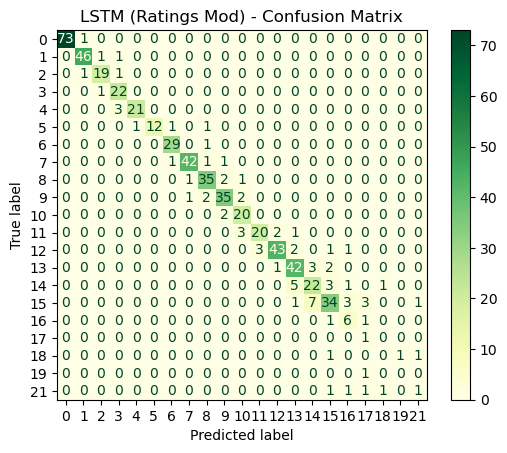

In [25]:
labels_list = []
predict_list = []
for x_var, labels in test_M:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_LSTM_M(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
labels_LSTM = np.sort(np.unique(np.concatenate((labels_list, predict_list))))
cmatrix_LSTM_M = confusion_matrix(labels_list, predict_list)
disp_LSTM_M = ConfusionMatrixDisplay(confusion_matrix = cmatrix_LSTM_M, display_labels = labels_LSTM)
disp_LSTM_M.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('LSTM (Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_LSTM_M.png')
plt.show()

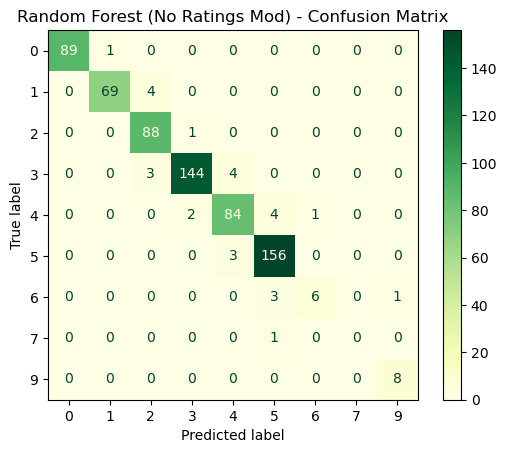

In [26]:
data_y_NM_pred = RF_NM.predict(data_X_test)
cmatrix_RF_NM = confusion_matrix(data_y_NM_test, data_y_NM_pred)
labels = np.sort(np.unique(data_y_NM_train))
disp_RF_NM = ConfusionMatrixDisplay(confusion_matrix = cmatrix_RF_NM, display_labels = labels)
disp_RF_NM.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('Random Forest (No Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_RF_NM.png')
plt.show()

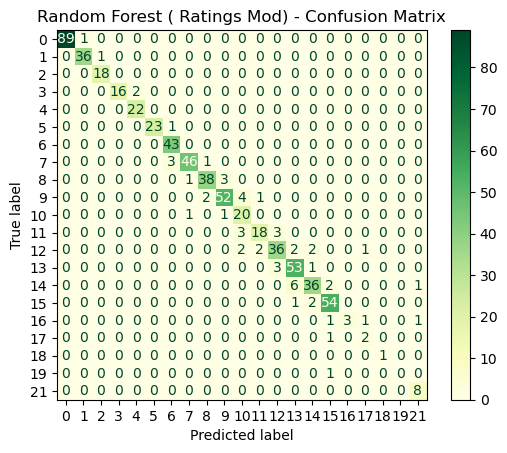

In [27]:
data_y_M_pred = RF_M.predict(data_X_test)
cmatrix_RF_M = confusion_matrix(data_y_M_test, data_y_M_pred)
labels = np.sort(np.unique(data_y_M_train))
disp_RF_M = ConfusionMatrixDisplay(confusion_matrix = cmatrix_RF_M, display_labels = labels)
disp_RF_M.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('Random Forest ( Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_RF_M.png')
plt.show()

In [28]:
path = 'Data_XY_L6_v2.xlsx'
#train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

#Sample Data
pdata_X, pdata_y_NM = next(iter(train_NM))
# Initialize the attribution algorithm with the model
integrated_gradients_RNN_NM = IntegratedGradients(model_RNN_NM)
integrated_gradients_LSTM_NM = IntegratedGradients(model_LSTM_NM)

# Ask the algorithm to attribute our output target to 
noise_tunnel_RNN_NM = NoiseTunnel(integrated_gradients_RNN_NM)
attributions_RNN = noise_tunnel_RNN_NM.attribute(pdata_X, nt_type='smoothgrad_sq',
                         nt_samples=10, target=pdata_y_NM)

# Ask the algorithm to attribute our output target to 
noise_tunnel_LSTM_NM = NoiseTunnel(integrated_gradients_LSTM_NM)
attributions_LSTM = noise_tunnel_LSTM_NM.attribute(pdata_X, nt_type='smoothgrad_sq',
                         nt_samples=10, target=pdata_y_NM)

In [29]:
Att_RNN = attributions_RNN.detach().numpy()
Att_Total = Att_RNN.sum()
Att_RNN_Features = (Att_RNN.sum(0).sum(0)/Att_Total)

Att_RNN = attributions_RNN.detach().numpy()
Att_Total = Att_RNN.sum()
Att_RNN_Seq = (Att_RNN.sum(0).sum(1)/Att_Total)

Att_LSTM = attributions_LSTM.detach().numpy()
Att_Total = Att_LSTM.sum()
Att_LSTM_Features = (Att_LSTM.sum(0).sum(0)/Att_Total)

Att_LSTM = attributions_LSTM.detach().numpy()
Att_Total = Att_LSTM.sum()
Att_LSTM_Seq = (Att_LSTM.sum(0).sum(1)/Att_Total)

feature_list = np.array(pd.read_excel(path, sheet_name = 'X').columns.tolist()[4:])

In [30]:
RNN_features_name = feature_list[Att_RNN_Features.argsort()[::-1]]
RNN_features_sorted = np.sort(Att_RNN_Features)[::-1]
LSTM_features_name = feature_list[Att_LSTM_Features.argsort()[::-1]]
LSTM_features_sorted = np.sort(Att_LSTM_Features)[::-1]

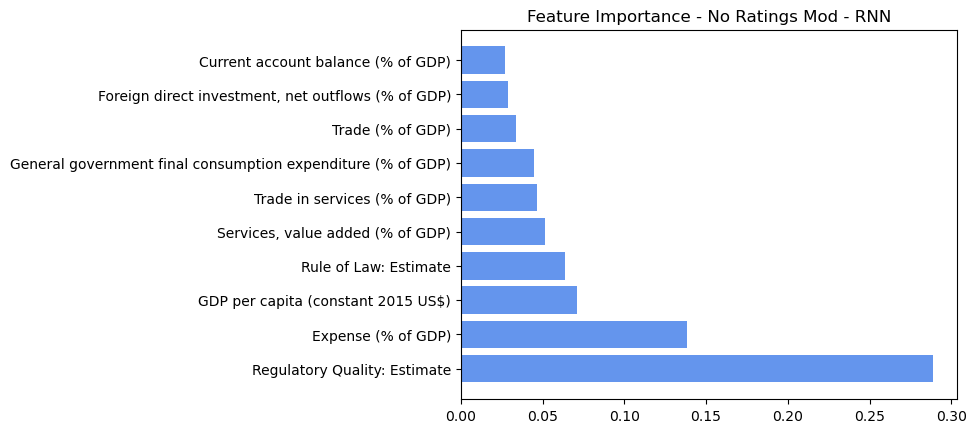

In [31]:
plt.figure()
plt.title("Feature Importance - No Ratings Mod - RNN")
plt.barh(RNN_features_name[:10], RNN_features_sorted[:10],
       color="cornflowerblue", align="center")
#plt.savefig('pics/FI_RNN_NM.png')
plt.show()

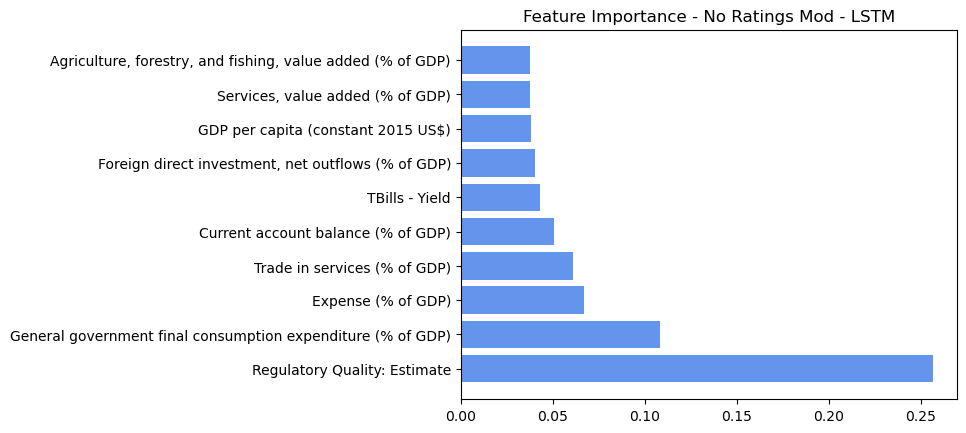

In [32]:
plt.figure()
plt.title("Feature Importance - No Ratings Mod - LSTM")
plt.barh(LSTM_features_name[:10], LSTM_features_sorted[:10],
       color="cornflowerblue", align="center")
#plt.savefig('pics/FI_LSTM_NM.png')
plt.show()

In [33]:
RF_NM_importances = RF_NM.feature_importances_
RF_M_importances = RF_M.feature_importances_

RF_NM_features_name = feature_list[RF_NM_importances.argsort()[::-1]]
RF_NM_features_sorted = np.sort(RF_NM_importances)[::-1]
RF_M_features_name = feature_list[RF_M_importances.argsort()[::-1]]
RF_M_features_sorted = np.sort(RF_M_importances)[::-1]

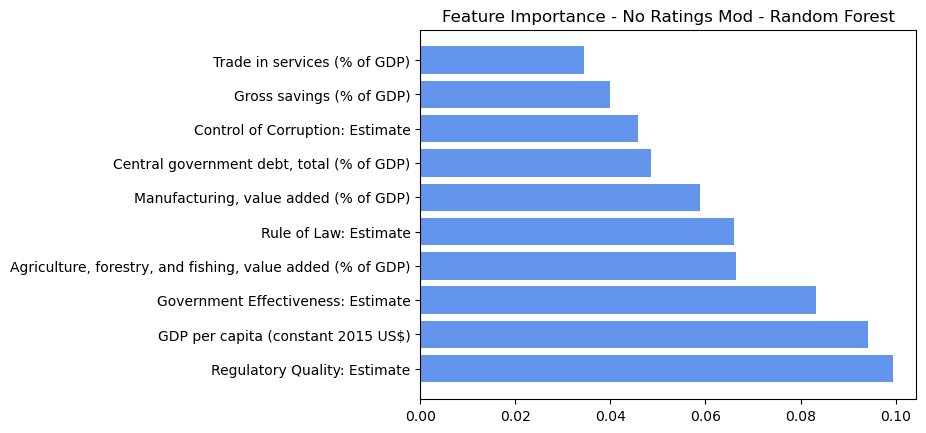

In [34]:
plt.figure()
plt.title("Feature Importance - No Ratings Mod - Random Forest")
plt.barh(RF_NM_features_name[:10], RF_NM_features_sorted[:10],
       color="cornflowerblue", align="center")
#plt.savefig('pics/FI_RF_NM.png')
plt.show()

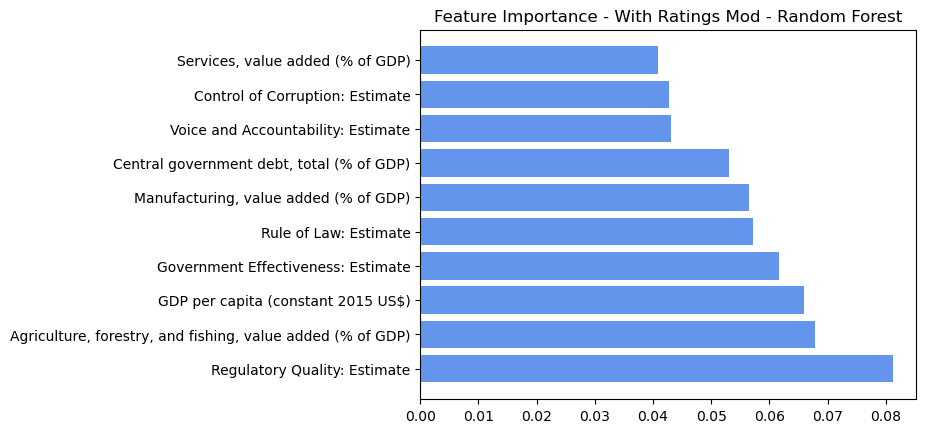

In [35]:
plt.figure()
plt.title("Feature Importance - With Ratings Mod - Random Forest")
plt.barh(RF_M_features_name[:10], RF_M_features_sorted[:10],
       color="cornflowerblue", align="center")
#plt.savefig('pics/FI_RF_M.png')
plt.show()

In [31]:
#Load Data, Lag = 6
#Load transformed data
device = torch.device('cpu')
path = 'Data_XY_L6_v2.xlsx'
offset = 4
batch_size = 64

data_x = pd.read_excel(path, sheet_name = 'X')
data_y_NM = pd.read_excel(path, sheet_name = 'y_NM').values.ravel()
data_y_M = pd.read_excel(path, sheet_name = 'y_M').values.ravel()
data_meta = data_x.iloc[:, :3].drop_duplicates().reset_index(drop = True)
a, b = data_x.shape
p = len(data_x.columns.tolist()[offset:])
n = int(data_x.loc[0, 'Lag'].split('-')[1])
m = int(a/n)
pdata_x = torch.from_numpy(data_x.iloc[:, offset:].values.astype(np.float32))
pdata_y_NM = torch.tensor(data_y_NM)
pdata_y_M = torch.tensor(data_y_M)
pdata_x = pdata_x.view(m, n, p).float()

split = 0.75
m_train = math.ceil(m * split)
m_test = math.floor(m * (1 - split))

generator1 = torch.Generator().manual_seed(seed)
m_perm = torch.randperm(m, generator = generator1)
train_idx = m_perm[:m_train]
test_idx = m_perm[m_train:]
pdata_x_train = pdata_x[train_idx, :]
pdata_x_test = pdata_x[test_idx, :]
pdata_y_NM_train = pdata_y_NM[train_idx]
pdata_y_NM_test = pdata_y_NM[test_idx]
pdata_y_M_train = pdata_y_M[train_idx]
pdata_y_M_test = pdata_y_M[test_idx]

pdata_train_NM = MacroDataset(pdata_x_train, pdata_y_NM_train)
pdata_test_NM = MacroDataset(pdata_x_test, pdata_y_NM_test)
pdata_train_M = MacroDataset(pdata_x_train, pdata_y_M_train)
pdata_test_M = MacroDataset(pdata_x_test, pdata_y_M_test)


train_NM = torch.utils.data.DataLoader(pdata_train_NM, batch_size = batch_size)
test_NM = torch.utils.data.DataLoader(pdata_test_NM, batch_size = batch_size)
train_M = torch.utils.data.DataLoader(pdata_train_M, batch_size = batch_size)
test_M = torch.utils.data.DataLoader(pdata_test_M, batch_size = batch_size)

labels = []
for x, y in train_NM:
    labels += list(y.numpy())
labels = np.array(labels)
counts = []
for i in range(10):
    n = len(labels[labels == i])
    if n == 0:
        n = len(labels)/4
    counts.append(n)
counts = np.array(counts)
total = counts.sum()
weights = total/counts
weights_NM_6 = torch.from_numpy(weights).float()

labels = []
for x, y in train_M:
    labels += list(y.numpy())
labels = np.array(labels)
counts = []
for i in range(22):
    n = len(labels[labels == i])
    if n == 0:
        n = len(labels)/4
    counts.append(n)
counts = np.array(counts)
total = counts.sum()
weights = total/counts
weights_M_6 = torch.from_numpy(weights).float()

# Hyper-parameters 
num_epochs = 201
learning_rate = 0.001
dropout = 0.075

input_size = next(iter(train_NM))[0].size()[2]
sequence_length = next(iter(train_NM))[0].size()[1]
hidden_size = 256
num_layers = 2

num_classes = 10
criterion = nn.CrossEntropyLoss(weight = weights_NM_6)
#RNN No Rating Modifiers
model_RNN_NM = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_NM.parameters(), lr=learning_rate)
train_model(model_RNN_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)

#LSTM No Rating Modifiers
model_LSTM_NM = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_NM.parameters(), lr=learning_rate)
train_model(model_LSTM_NM, criterion, optimizer, train_NM, test_NM, num_epochs = num_epochs)

num_classes = 22
criterion = nn.CrossEntropyLoss(weight = weights_M_6)
#RNN Rating Modifiers
model_RNN_M = RNN(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_RNN_M.parameters(), lr=learning_rate)
train_model(model_RNN_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)

#LSTM Rating Modifiers
model_LSTM_M = LSTM(input_size, hidden_size, num_layers, num_classes, dropout = dropout).to(device)
optimizer = torch.optim.Adam(model_LSTM_M.parameters(), lr=learning_rate)
train_model(model_LSTM_M, criterion, optimizer, train_M, test_M, num_epochs = num_epochs)

Epoch: 0, Training Accuracy: 54.85 %
Epoch: 100, Training Accuracy: 98.24 %
Epoch: 200, Training Accuracy: 96.8 %
Testing Accuracy: 92.22 %
Epoch: 0, Training Accuracy: 62.29 %
Epoch: 100, Training Accuracy: 97.74 %
Epoch: 200, Training Accuracy: 99.61 %
Testing Accuracy: 94.04 %
Epoch: 0, Training Accuracy: 32.75 %
Epoch: 100, Training Accuracy: 92.17 %
Epoch: 200, Training Accuracy: 97.19 %
Testing Accuracy: 85.76 %
Epoch: 0, Training Accuracy: 34.29 %
Epoch: 100, Training Accuracy: 96.86 %
Epoch: 200, Training Accuracy: 98.24 %
Testing Accuracy: 87.75 %


([34.28886438809261,
  31.808158765159867,
  45.70011025358324,
  56.560088202866595,
  58.93054024255788,
  62.954796030871,
  66.09702315325248,
  69.79051819184123,
  71.05843439911797,
  73.26350606394708,
  75.52370452039692,
  73.04299889746417,
  76.35060639470782,
  80.54024255788313,
  79.10694597574421,
  78.61080485115767,
  80.42998897464167,
  81.09151047409041,
  80.37486218302095,
  83.8478500551268,
  84.6747519294377,
  87.21058434399119,
  85.61190738699008,
  86.16317530319735,
  86.76957001102537,
  85.6670341786108,
  87.21058434399119,
  86.87982359426681,
  84.39911797133406,
  88.09261300992283,
  86.27342888643881,
  85.11576626240353,
  89.47078280044101,
  88.53362734288865,
  90.73869900771776,
  88.6438809261301,
  91.06945975744212,
  90.2425578831312,
  90.40793825799338,
  92.17199558985666,
  92.33737596471886,
  93.55016538037486,
  92.2271223814774,
  90.90407938257994,
  92.77839029768468,
  92.06174200661522,
  88.25799338478501,
  89.80154355016538

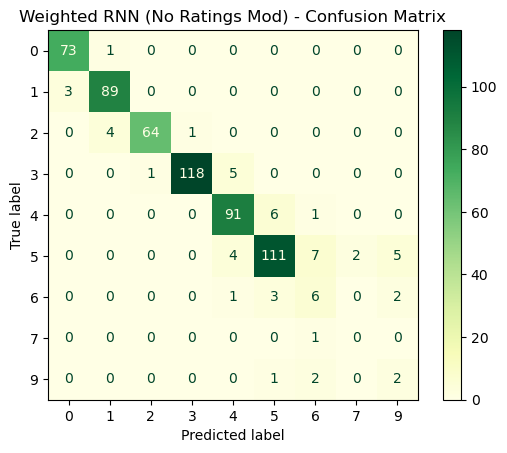

In [37]:
labels_list = []
predict_list = []
for x_var, labels in test_NM:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_RNN_NM(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
labels_RNN = np.sort(np.unique(np.concatenate((labels_list, predict_list))))
cmatrix_RNN_NM = confusion_matrix(labels_list, predict_list)
disp_RNN_NM = ConfusionMatrixDisplay(confusion_matrix = cmatrix_RNN_NM, display_labels = labels_RNN)
disp_RNN_NM.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('Weighted RNN (No Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_WRNN_NM.png')
plt.show()

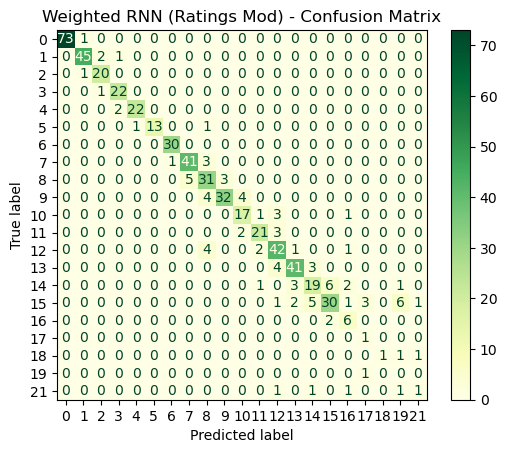

In [38]:
labels_list = []
predict_list = []
for x_var, labels in test_M:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_RNN_M(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
labels_RNN = np.sort(np.unique(np.concatenate((labels_list, predict_list))))
cmatrix_RNN_M = confusion_matrix(labels_list, predict_list)
disp_RNN_M = ConfusionMatrixDisplay(confusion_matrix = cmatrix_RNN_M, display_labels = labels_RNN)
disp_RNN_M.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('Weighted RNN (Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_WRNN_M.png')
plt.show()

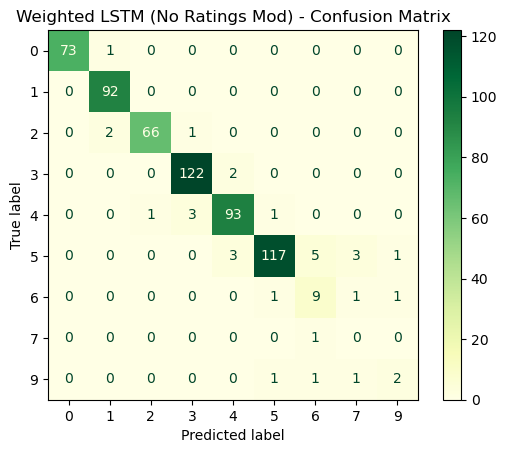

In [39]:
labels_list = []
predict_list = []
for x_var, labels in test_NM:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_LSTM_NM(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
labels_LSTM = np.sort(np.unique(np.concatenate((labels_list, predict_list))))
cmatrix_LSTM_NM = confusion_matrix(labels_list, predict_list)
disp_LSTM_NM = ConfusionMatrixDisplay(confusion_matrix = cmatrix_LSTM_NM, display_labels = labels_LSTM)
disp_LSTM_NM.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('Weighted LSTM (No Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_WLSTM_NM.png')
plt.show()

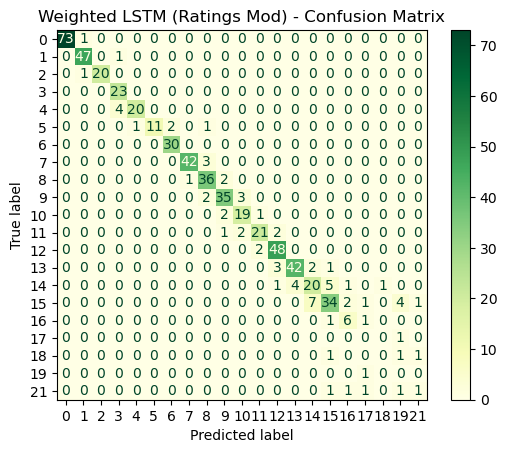

In [40]:
labels_list = []
predict_list = []
for x_var, labels in test_M:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_LSTM_M(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
labels_LSTM = np.sort(np.unique(np.concatenate((labels_list, predict_list))))
cmatrix_LSTM_M = confusion_matrix(labels_list, predict_list)
disp_LSTM_M = ConfusionMatrixDisplay(confusion_matrix = cmatrix_LSTM_M, display_labels = labels_LSTM)
disp_LSTM_M.plot(include_values = True , cmap = 'YlGn', xticks_rotation = 'horizontal')
plt.title('Weighted LSTM (Ratings Mod) - Confusion Matrix')
#plt.savefig('pics/CM_WLSTM_M.png')
plt.show()

In [41]:
path = 'Data_XY_L6_v2.xlsx'
#train_NM, test_NM, train_M, test_M = load_data(path, seed = seed)

#Sample Data
pdata_X, pdata_y_NM = next(iter(train_NM))
# Initialize the attribution algorithm with the model
integrated_gradients_RNN_NM = IntegratedGradients(model_RNN_NM)
integrated_gradients_LSTM_NM = IntegratedGradients(model_LSTM_NM)

# Ask the algorithm to attribute our output target to 
noise_tunnel_RNN_NM = NoiseTunnel(integrated_gradients_RNN_NM)
attributions_RNN = noise_tunnel_RNN_NM.attribute(pdata_X, nt_type='smoothgrad_sq',
                         nt_samples=10, target=pdata_y_NM)

# Ask the algorithm to attribute our output target to 
noise_tunnel_LSTM_NM = NoiseTunnel(integrated_gradients_LSTM_NM)
attributions_LSTM = noise_tunnel_LSTM_NM.attribute(pdata_X, nt_type='smoothgrad_sq',
                         nt_samples=10, target=pdata_y_NM)

In [42]:
Att_RNN = attributions_RNN.detach().numpy()
Att_Total = Att_RNN.sum()
Att_RNN_Features = (Att_RNN.sum(0).sum(0)/Att_Total)

Att_RNN = attributions_RNN.detach().numpy()
Att_Total = Att_RNN.sum()
Att_RNN_Seq = (Att_RNN.sum(0).sum(1)/Att_Total)

Att_LSTM = attributions_LSTM.detach().numpy()
Att_Total = Att_LSTM.sum()
Att_LSTM_Features = (Att_LSTM.sum(0).sum(0)/Att_Total)

Att_LSTM = attributions_LSTM.detach().numpy()
Att_Total = Att_LSTM.sum()
Att_LSTM_Seq = (Att_LSTM.sum(0).sum(1)/Att_Total)

feature_list = np.array(pd.read_excel(path, sheet_name = 'X').columns.tolist()[4:])

In [43]:
RNN_features_name = feature_list[Att_RNN_Features.argsort()[::-1]]
RNN_features_sorted = np.sort(Att_RNN_Features)[::-1]
LSTM_features_name = feature_list[Att_LSTM_Features.argsort()[::-1]]
LSTM_features_sorted = np.sort(Att_LSTM_Features)[::-1]

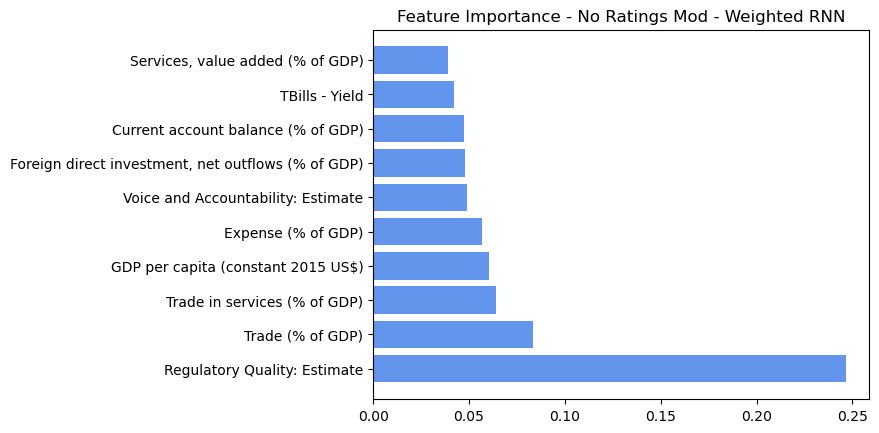

In [44]:
plt.figure()
plt.title("Feature Importance - No Ratings Mod - Weighted RNN")
plt.barh(RNN_features_name[:10], RNN_features_sorted[:10],
       color="cornflowerblue", align="center")
#plt.savefig('pics/FI_WRNN_NM.png')
plt.show()

<BarContainer object of 10 artists>

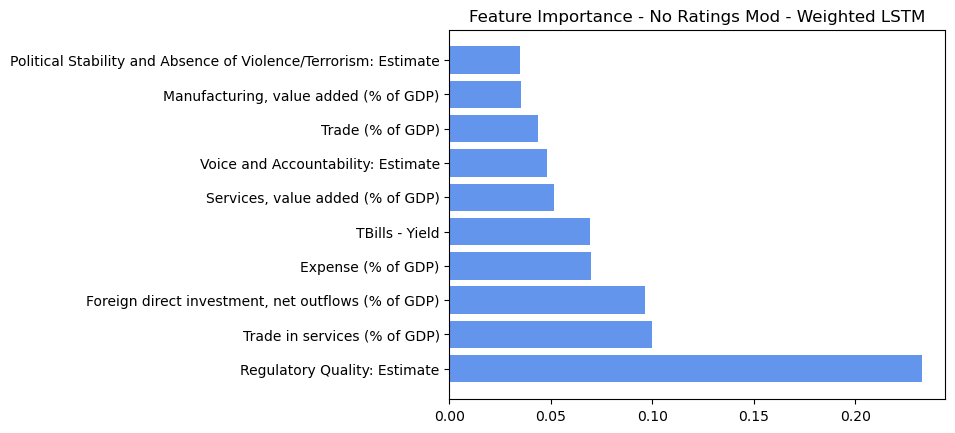

In [45]:
plt.figure()
plt.title("Feature Importance - No Ratings Mod - Weighted LSTM")
plt.barh(LSTM_features_name[:10], LSTM_features_sorted[:10],
       color="cornflowerblue", align="center")
#plt.savefig('pics/FI_WLSTM_NM.png')

In [46]:
labels_list = []
predict_list = []
for x_var, labels in test_NM:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_LSTM_NM(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
data_meta_NM = data_meta.iloc[test_idx]
data_meta_NM['Rating - Pred'] = predict_list
data_meta_NM = data_meta_NM.replace(ratings_mapping_NM)
data_meta_NM['Check'] = data_meta_NM['Rating'] == data_meta_NM['Rating - Pred']
data_meta_NM_LSTM = data_meta_NM[data_meta_NM['Check'] == False]
data_meta_NM_LSTM.head(10)

,Country Code,Period,Rating,Rating - Pred,Check
367,BLZ,2021 Q3,9,5,False
2409,ZMB,2019 Q3,6,5,False
1131,JAM,2010 Q1,5,6,False
71,AZE,2011 Q4,3,4,False
716,GEO,2011 Q3,5,4,False
773,GRC,2011 Q4,7,6,False
191,BHR,2010 Q4,2,3,False
344,BLZ,2015 Q4,5,7,False
361,BLZ,2020 Q1,5,7,False
779,GRC,2013 Q2,5,6,False


In [27]:
pdata_y_NM = torch.tensor(data_y_NM)
pdata_NM = MacroDataset(pdata_x, pdata_y_NM)
NM = torch.utils.data.DataLoader(pdata_NM, batch_size = batch_size)

labels_list = []
predict_list = []
for x_var, labels in NM:
    labels = labels.to(device)
    labels = list(labels.numpy())
    labels_list += labels
    outputs = model_LSTM_NM(x_var)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    predicted = list(predicted.numpy())
    predict_list += predicted
labels_list = np.array(labels_list)
predict_list = np.array(predict_list)
data_meta_NM = data_meta.copy()
data_meta_NM['Rating - Pred'] = predict_list
data_meta_NM = data_meta_NM.replace(ratings_mapping_NM)
data_meta_NM['Check'] = data_meta_NM['Rating'] == data_meta_NM['Rating - Pred']
data_meta_NM_whole = data_meta_NM.copy()
#data_meta_NM_whole.to_excel('Predict_L6.xlsx', index = False)
data_meta_NM_whole.head(10)

NameError: name 'data_y_NM' is not defined

In [48]:
path = 'Data_XY_L1_v2.xlsx'
data_x = pd.read_excel(path, sheet_name = 'X')
rf_x = data_x.iloc[:, 4:].values
data_meta = data_x.iloc[:, :3].drop_duplicates().reset_index(drop = True)
rf_predict = RF_NM.predict(rf_x)
data_meta_RF = data_meta.copy()
data_meta_RF['Rating - Pred'] = rf_predict
data_meta_RF = data_meta_RF.replace(ratings_mapping_NM)
data_meta_RF['Check'] = data_meta_RF['Rating'] == data_meta_RF['Rating - Pred']
#data_meta_RF.to_excel('Predict_L1_RF.xlsx', index = False)

Text(0.5, 1.0, 'Correlation Heatmap')

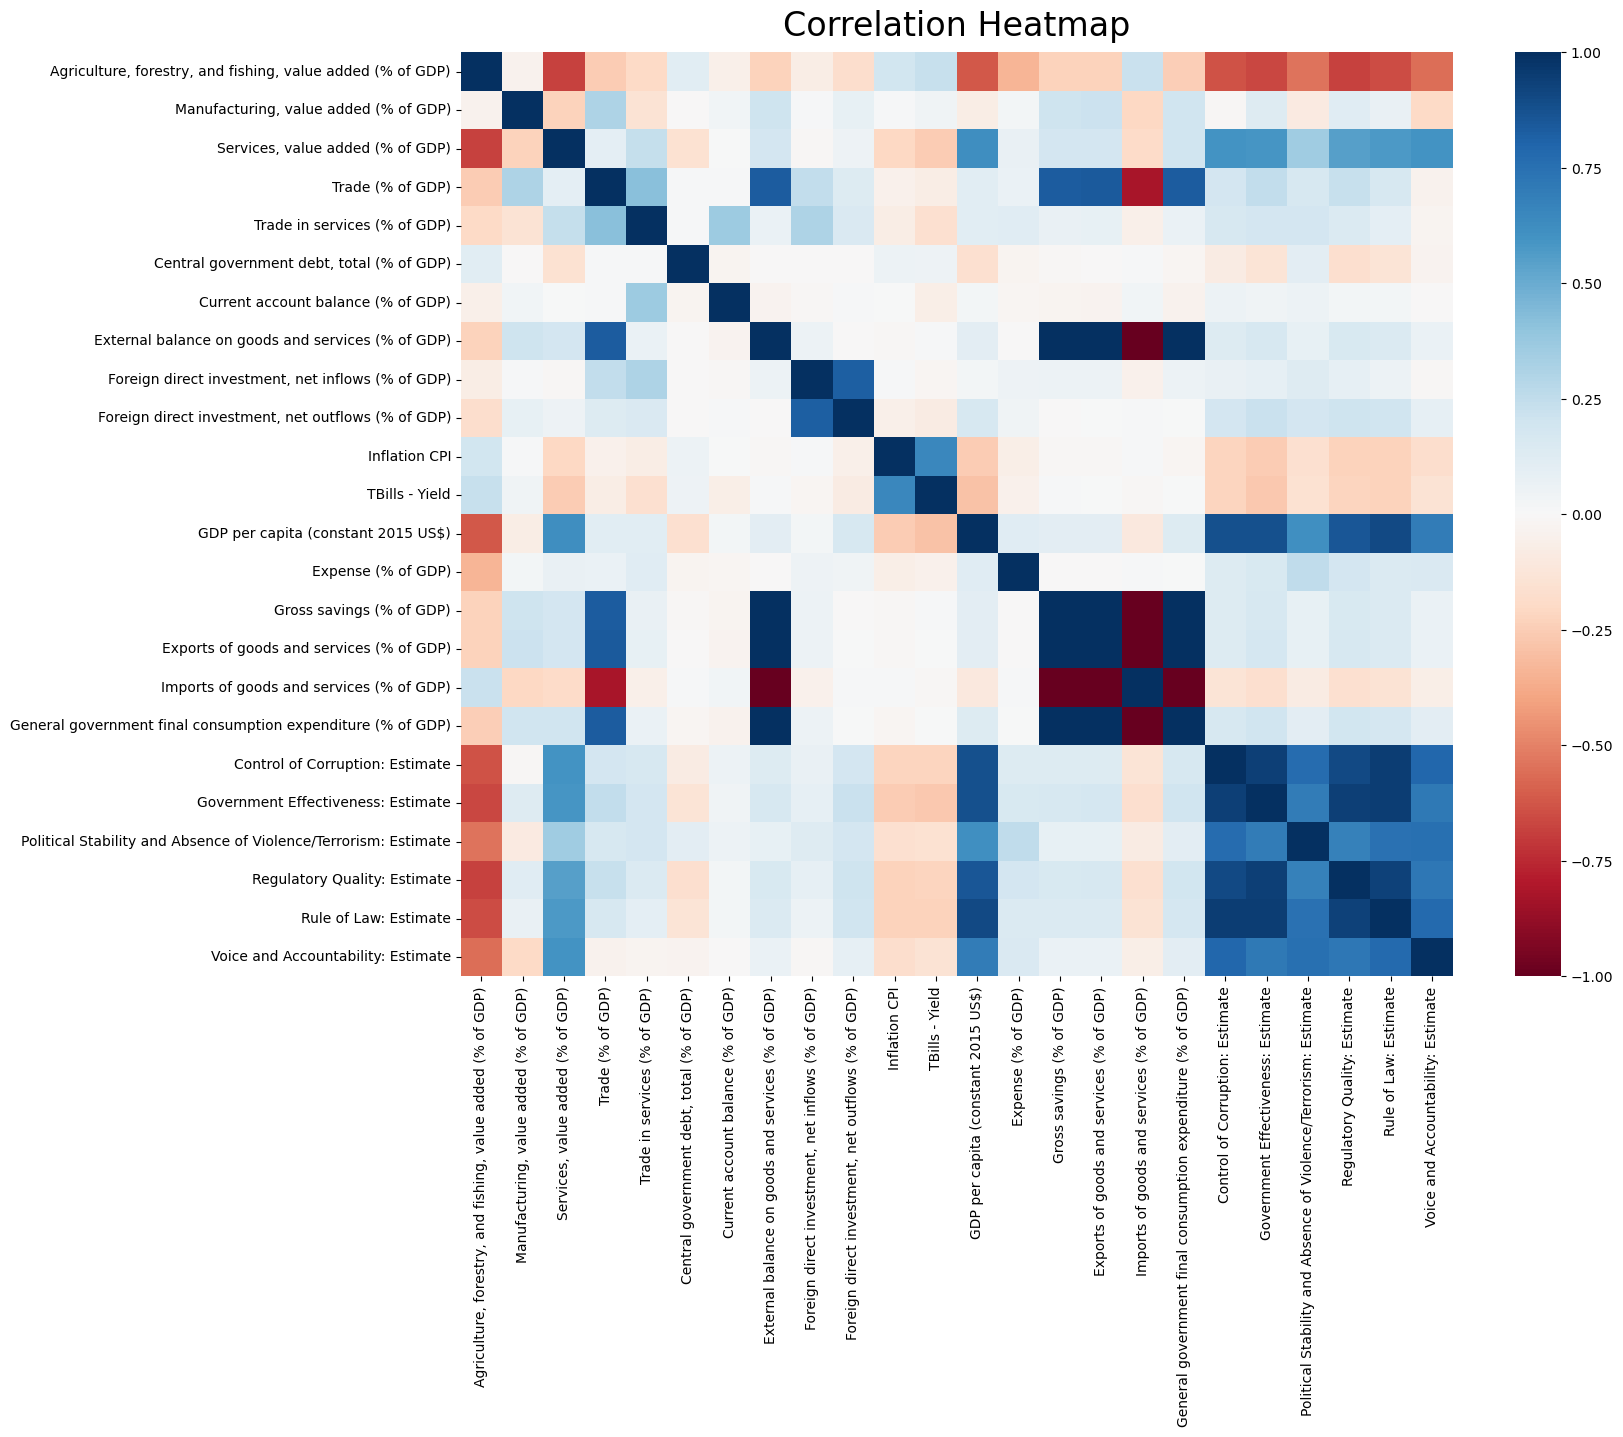

In [49]:
path = 'Data_XY_L1_v2.xlsx'
data_L1 = pd.read_excel(path, sheet_name = 'X')
X = data_L1.iloc[:, 4:]
X_corr = X.corr()

plt.figure(figsize=(16, 12))
heatmap = sns.heatmap(X_corr, vmin=-1, vmax=1, annot=False, cmap = 'RdBu')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':24}, pad=12)

Text(0, 0.5, 'Frequency')

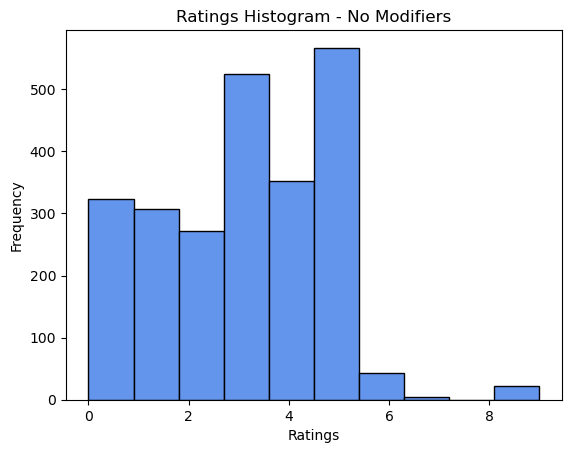

In [50]:
path = "Data_XY_L6_v2.xlsx"
y_NM = pd.read_excel(path, sheet_name = "y_NM")
NM_hist = plt.hist(y_NM['Labels'], bins = 10, color = 'cornflowerblue', edgecolor = 'black')
plt.title('Ratings Histogram - No Modifiers') 
plt.xlabel('Ratings') 
plt.ylabel('Frequency') 

Text(0, 0.5, 'Frequency')

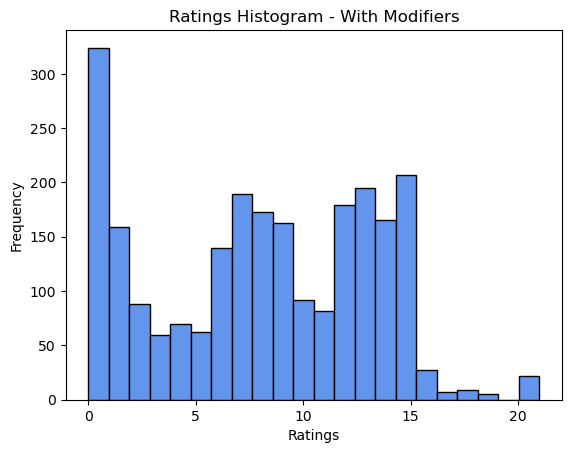

In [51]:
y_M = pd.read_excel(path, sheet_name = "y_M")
M_hist = plt.hist(y_M['Labels'], bins = 22, color = 'cornflowerblue', edgecolor = 'black')
plt.title('Ratings Histogram - With Modifiers') 
plt.xlabel('Ratings') 
plt.ylabel('Frequency') 